https://arxiv.org/abs/2305.14314 (original paper) <br/>
https://github.com/artidoro/qlora (qlora official github repo) <br/>
https://github.com/TimDettmers/bitsandbytes (bitsandbytes github 8-bit quantisation technique) <br/>
https://github.com/huggingface/peft (hugging face fine-tuning lib) <br/>
https://arxiv.org/pdf/2110.02861.pdf (paper quantile quantisation) <br/>
https://en.wikipedia.org/wiki/Quantile (quantile) <br/>
https://timdettmers.com/2022/08/17/llm-int8-and-emergent-features/ (blog: quantization overview) <br/>
https://docs.nvidia.com/deeplearning/tensorrt/tensorflow-quantization-toolkit/docs/docs/intro_to_quantization.html (basics of general quantization).

In [422]:
import torch
import sys
import matplotlib.pyplot as plt
import numpy as np

In [8]:
# basic idea is quantise the original model weights with low bits than original bits for reducing 
# original weight memory, and use the lora technique to fine tune the down stream tasks without updating 
# the pre trained weights.

# why this is exciting idea?
# LLaMA 65B requires ~780GB GPU memory.🥵
# same model with qlora techniques can run on ~48GB single GPU memory.
# can be trained within 24 hrs time.

x data type:  torch.float32
x memory: 381 MB
y data type:  torch.int8
y memory: 95 MB


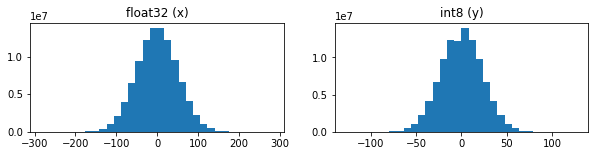

In [132]:
# todo: name may be different need to check
# todo: example need to be verified
# linear quantisation:
# naive 8bit int quantisation from float32 bit.
# element_size: returns bytes of each element in the tensor.
# numel: returns number of elements.
# memory is reduced drastically.
# at the same time distribution is sort of intact.

x = torch.randn(100000000) * 50
memory_of_x = round((x.element_size() * x.numel())/(1024**2))
print('x data type: ', x.dtype)
print(f"x memory: {memory_of_x} MB")
abs_max_x = x.max().abs()

y = (127 * (x/abs_max_x)).round().to(torch.int8)
memory_of_y = round((y.element_size() * y.numel())/(1024*1024))
print('y data type: ', y.dtype)
print(f"y memory: {memory_of_y} MB")


_, axs = plt.subplots(1, 2, figsize=(10, 2))
for title, ax, data in zip(('float32 (x)', 'int8 (y)'), axs, (x, y)):
    ax.hist(data.numpy(), bins=32)
    ax.set_title(title)
plt.show();

x data type:  torch.float32
x memory: 381 MB
y data type:  torch.int8
y memory: 95 MB


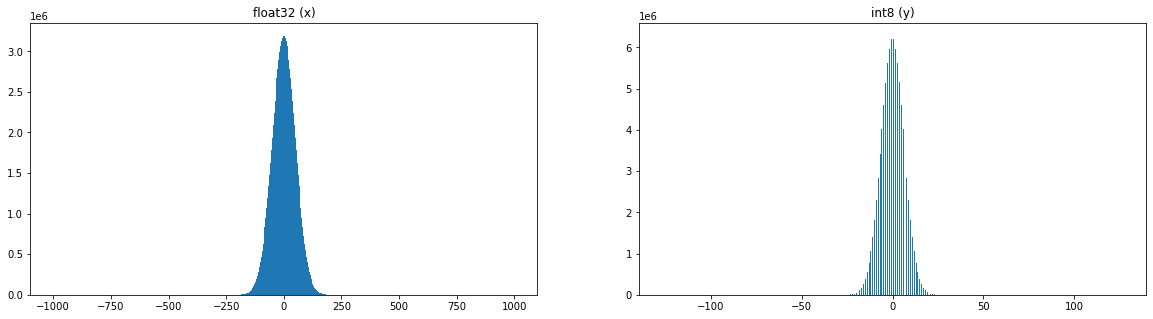

In [133]:
# failure case when there are outliers. then this technique dosn't properly preserve the distributions.
# white strip is the missing bins this happens due to this outlier and eneven property of the input data.

# big outlier issue: normal distribution (scaled with 5) is concated with extreme outlier value of 1000.
x = torch.cat([torch.randn(99999990) * 50, torch.tensor([1000.0, -1000.0])])

# narrow range issue: this is narrow range issue example.
# x = torch.randn(100000000) * 0.01

memory_of_x = round((x.element_size() * x.numel())/(1024**2))
print('x data type: ', x.dtype)
print(f"x memory: {memory_of_x} MB")
abs_max_x = x.max().abs()

y = (127 * (x/abs_max_x)).round().to(torch.int8)
memory_of_y = round((y.element_size() * y.numel())/(1024*1024))
print('y data type: ', y.dtype)
print(f"y memory: {memory_of_y} MB")


_, axs = plt.subplots(1, 2, figsize=(20, 5))
for title, ax, data in zip(('float32 (x)', 'int8 (y)'), axs, (x, y)):
    ax.hist(data.numpy(), bins=500)
    ax.set_title(title)
plt.show()

x data type:  torch.float32
x memory: 381 MB
y data type:  torch.int8
y memory: 95 MB


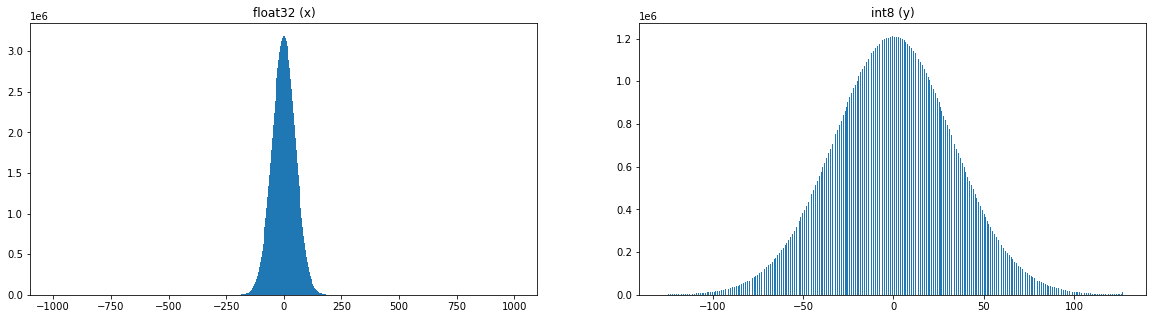

In [134]:
# block-wise k-bit quantisation:
# split the input into buckets and run the naive quantisation on those bucket,
# this will help to side step from the outlier issues.

def quantise(x):
    abs_max_x = x.max().abs()
    return (127 * (x/abs_max_x)).round().to(torch.int8)

block_size = 10000
x = torch.cat([torch.randn(99999990) * 50, torch.tensor([1000.0, -1000.0])])
print('x data type: ', x.dtype)
print(f"x memory: {memory_of_x} MB")

x_chunked_lst = x.chunk(block_size)
x_chunked_lst_quantised = map(quantise, x_chunked_lst)

y = torch.cat(list(x_chunked_lst_quantised))
memory_of_y = round((y.element_size() * y.numel())/(1024*1024))
print('y data type: ', y.dtype)
print(f"y memory: {memory_of_y} MB")


_, axs = plt.subplots(1, 2, figsize=(20, 5))
for title, ax, data in zip(('float32 (x)', 'int8 (y)'), axs, (x, y)):
    ax.hist(data.numpy(), bins=500)
    ax.set_title(title)
plt.show()

In [135]:
# gradient memory foot print issue:
# in parameter efficient fine tuning like lora, main memory increase not in actual lora paramerts but 
# instead of gradient memory during backprop.
# e.g. 7B LLaMA with batch size of 1 and lora weight == 0.2% of the original weight only takes ~25MB but 
# it's gradient takes ~567MB memory!.

In [136]:
# 4-bit normal float quantisation:
# build on top of "quantile quantization" technique, this ensures each bin equal number of items assigned.
# "k-quantiles" buckets set of items into almost equal number in k bcuket. 
# some common quantiles are "quartiles (4 groups), percentile (100 groups)".

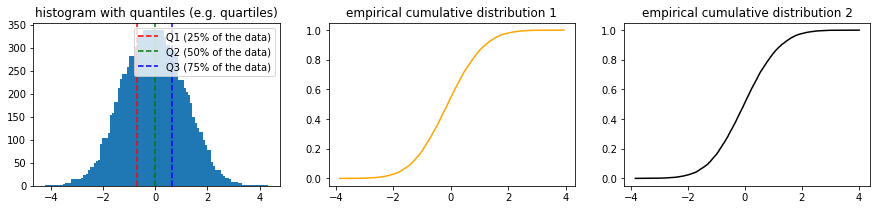

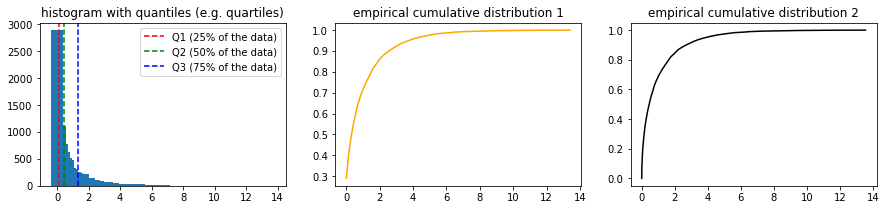

In [301]:
# histogram:
# sort the item in the set, and bucket list into required number of bins and start putting each item
# into respective buckets.
# hist[:-1]: extra boundary needs to be removed.

# plot normal and skewed distribution
x1 = torch.randn(10000)
x2 = torch.pow(torch.randn(10000), 2)
for x in (x1, x2):
    hist = torch.histogram(x, bins=100)

    _, axs = plt.subplots(1, 3, figsize=(15, 3))
    ax1, ax2, ax3 = axs[0], axs[1], axs[2]

    # hist
    ax1.bar(hist[1][:-1],hist[0]);

    # get quartiles
    # expensive operation
    # sorting requires: nlogn
    q1 = torch.quantile(x, 0.25).item()
    q2 = torch.quantile(x, 0.50).item()
    q3 = torch.quantile(x, 0.75).item()

    ax1.axvline(q1, color='r', linestyle='--', label='Q1 (25% of the data)');
    ax1.axvline(q2, color='g', linestyle='--', label='Q2 (50% of the data)');
    ax1.axvline(q3, color='b', linestyle='--', label='Q3 (75% of the data)');
    ax1.set_title('histogram with quantiles (e.g. quartiles)')
    ax1.legend();

    # cdf on hist
    cdf = torch.cumsum(hist[0], dim=0)/len(x)
    ax2.plot(hist[1][:-1], cdf, color='orange')
    ax2.set_title('empirical cumulative distribution 1')

    # cdf on directly on data
    cdf2 = torch.arange(1, len(x)+1)/len(x)
    ax3.plot(x.clone().sort()[0], cdf2, color='black')
    ax3.set_title('empirical cumulative distribution 2')

plt.show();

CPU times: user 1.64 s, sys: 413 ms, total: 2.05 s
Wall time: 1.67 s


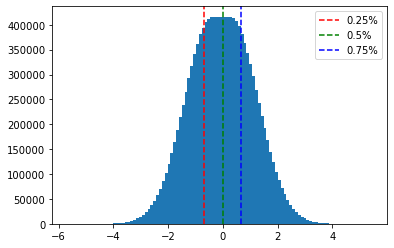

In [332]:
# SRAM-quantiles: fast quantile estimation algo:
# usual slow quantile estimation which uses logn to sort, for 10^8, it takes 1.37s.
# here sorting is slow because, it involves repeated store and load from DRAM.
# it uses GPU SRAM (known as shared memory). which is "15x" faster thant DRAM!.
# one issue is it has only 64kb per core.
# fast quantile estimation algo which chunk the big tensor such that each chunk fit into SRM and
# calculate cdf independently for each chunk on SRAM, then finally take average the quantiles on DRAM.
# todo: check how average is done??
# todo: need to check algo and check on GPU??

x = torch.randn(10000000)
n = len(x)
%time x = x.sort()[0] # nlogn 

# now for required quanitle, use : quantile index = quntaile % * len(x)
# this is usual way to get quantiles.
quartiles = [0.25, 0.5, 0.75]
quartiles_val = list(x[int(n*q)] for q in quantiles)

# plot quantiles on histogram
hist = torch.histogram(x)
plt.bar(hist[1][:-1], hist[0]);
for c, qv, lbl in zip(['r','g','b'], quartiles_val, quartiles):
    plt.axvline(qv, color=c, linestyle='--', label=f"{str(lbl)}%")
plt.legend();

In [336]:
# 4-bit normal float quantisation
# https://twitter.com/Tim_Dettmers/status/1661379379333681152 (ref)
# it trys to sequeze in higher precision data types FP16 to lower precision data types 4-bit in a such a way
# that each available entries in 4-bit occupied by the same number of items from the FP16. e.g. 5 items of 
# the F16 are sequezed into single position in 4-bit (beacause of the less space in 4bit), 
# this normal float quantisation technique ensures that all possition are sequezed with same number of items 
# around 5 items from F16.
# this is achievable due the property that trained neural network weights are more or less normaly distributed
# centered around mean.
# one interesting property of the weights which are distributed as standard normal distribution is that
# you can capture all kind of weight distribution by scaling with their respective standard deviation.

In [354]:
# quantization general formula:
# quantized_x = clamp(round(x/scale) + zero_point).
# scale = (beta - alpha) / (2^b - 1)
# [alpha, beta]: range of x.
# (2^b - 1): max range of target low precision, b-bits (e.g., 8 bits range = 255).
# zero_point = -round(beta * scale) - 2^(b-1); basically shifting the full range to zero-centered.

# dequantization:
# x = (quantized_x - zero_point)*scale.

In [363]:
# symmetric uniform quantization:
# the idea here is to keep the same number of elements between the negative and positive sides around zero. if
# we don't do this then it will create asymmetric quantization.
# for example, in 8 bits, we only consider the range [-127, 127]. We ignore one value for symmetry, implying our zero_point = 0.
# the simplified formula is quantized_x = clamp(round(x / scale)).
# scale = max_x / (2^(b-1)), where max_x = max(abs(alpha), abs(beta)).
# dequantization: x = quantized_x * scale.

x_memory: 38.1470 MB
quantized_x_memory: 9.5367 MB
quantized memory is 4 times lower than original input x
mse error:  0.00014


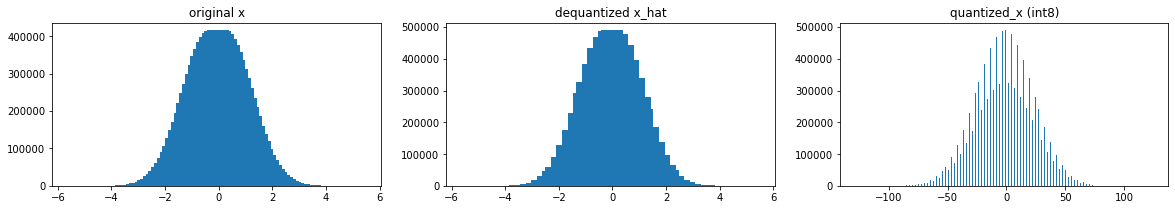

In [491]:
# torch.histogram doesn't works on int8 dtype.
# https://www.linkedin.com/advice/0/what-some-common-quantization-errors-how-can (error metrics)
torch.manual_seed(42)

def quantize(x, b):
    max_x = x.abs().max()
    scale = max_x/(2**(b-1))
    quantized_x = (x/scale).round()
    return quantized_x, scale

def dequantize(quantized_x, scale):
    return quantized_x * scale
    
x = torch.randn(10000000, dtype=torch.float32)
# x = torch.cat([torch.randn(100000, dtype=torch.float32), torch.tensor([25])])
# x = x.pow(2)

# quantize to 8-bit int from float32 bit
quantized_x, scale = quantize(x, 8)
quantized_x = quantized_x.to(dtype=torch.int8)

# dequantize from 8bit int to float32 bit
x_hat = dequantize(quantized_x, scale)
quantized_x, x_hat


# memory analysis
x_mem = (x.element_size() * x.numel())/(1024**2)
quantized_x_mem = (quantized_x.element_size() * quantized_x.numel())/(1024**2)
print(f'x_memory: {x_mem:.4f} MB')
print(f'quantized_x_memory: {quantized_x_mem:.4f} MB')
print(f'quantized memory is {(x_mem/quantized_x_mem):.0f} times lower than original input x')

# histogram analysis
_, axs = plt.subplots(1, 3, figsize=(20, 3))
for ax, xs, t in zip(axs, (x, x_hat, quantized_x), ('original x', 'dequantized x_hat', 'quantized_x (int8)')):
    hist = np.histogram(xs, bins=100)
    ax.bar(hist[1][:-1], hist[0])
    ax.set_title(t)

# mean squared error (MSE)
mse = (x-x_hat).pow(2).mean()
print('mse error: ', round(mse.item(), 5))

# todo: signal to noise ratio (SNR):
snr = None

# todo: peak signal to noise ratio (PSNR)
psnr = None


data distribution:  highly variable
x_memory: 0.3815 MB
quantized_x_memory: 0.0954 MB
quantized memory is 4 times lower than original input x
mse error:  0.09671
----------
data distribution:  periodic signal
x_memory: 0.3815 MB
quantized_x_memory: 0.0954 MB
quantized memory is 4 times lower than original input x
mse error:  0.11242
----------


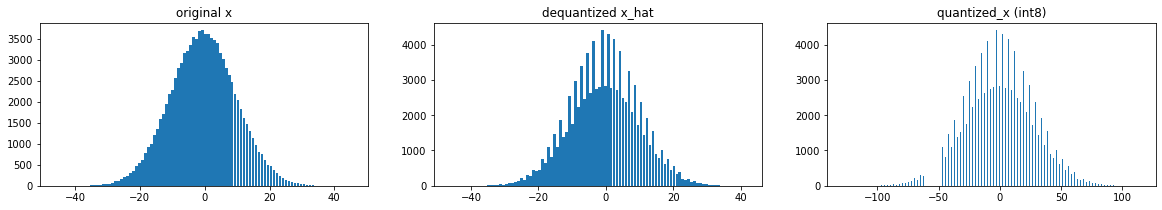

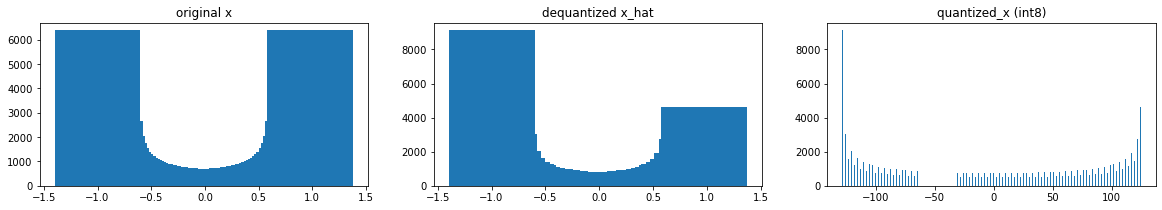

In [493]:
# issue with skewed input data, naive quantization method error increases
# as clearly quantization mse error increases as distribution is changes form standard normal to different
# distribution.

torch.manual_seed(42)

xs = [
   torch.randn(100000, dtype=torch.float32) * 10, # highly variable data points
   torch.sin(torch.linspace(0, 10 * np.pi, 100000)),  # periodic signal
]
    
for x, lbl in zip(xs, ('highly variable', 'periodic signal')):
    print('data distribution: ', lbl)
    # quantize to 8-bit int from float32 bit
    quantized_x, scale = quantize(x, 8)
    quantized_x = quantized_x.to(dtype=torch.int8)

    # dequantize from 8bit int to float32 bit
    x_hat = dequantize(quantized_x, scale)
    quantized_x, x_hat


    # memory analysis
    x_mem = (x.element_size() * x.numel())/(1024**2)
    quantized_x_mem = (quantized_x.element_size() * quantized_x.numel())/(1024**2)
    print(f'x_memory: {x_mem:.4f} MB')
    print(f'quantized_x_memory: {quantized_x_mem:.4f} MB')
    print(f'quantized memory is {(x_mem/quantized_x_mem):.0f} times lower than original input x')

    # histogram analysis
    _, axs = plt.subplots(1, 3, figsize=(20, 3))
    for ax, xs, t in zip(axs, (x, x_hat, quantized_x),\
                         ('original x', 'dequantized x_hat', 'quantized_x (int8)')):
        hist = np.histogram(xs, bins=100)
        ax.bar(hist[1][:-1], hist[0])
        ax.set_title(t)

    # mean squared error (MSE)
    mse = (x-x_hat).pow(2).mean()
    print('mse error: ', round(mse.item(), 5))

    # todo: signal to noise ratio (SNR):
    snr = None

    # todo: peak signal to noise ratio (PSNR)
    psnr = None
    
    print('----------')
